## Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('card_transaction_preprocessed.csv')
df.head(5)

,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,isMatchedCVV,cardAge,cardExpiration,daysSinceAddressChange,...,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_UNKNOWN
0,5000.0,98.55,0.0,False,False,False,True,518,2511,518,...,False,False,False,False,False,True,False,True,False,False
1,5000.0,74.51,0.0,True,False,False,True,577,2696,577,...,False,False,False,False,False,False,False,True,False,False
2,5000.0,7.47,0.0,False,False,False,True,605,3217,605,...,True,False,False,False,False,False,False,True,False,False
3,5000.0,7.47,0.0,False,False,False,True,637,3185,637,...,True,False,False,False,False,False,False,True,False,False
4,5000.0,71.18,0.0,True,False,False,True,231,4968,231,...,False,False,False,False,False,False,False,True,False,False


### Scaling numerical features

I will use min standard scaling to bring continuous variables into the same range for the use of Logistic Regression.

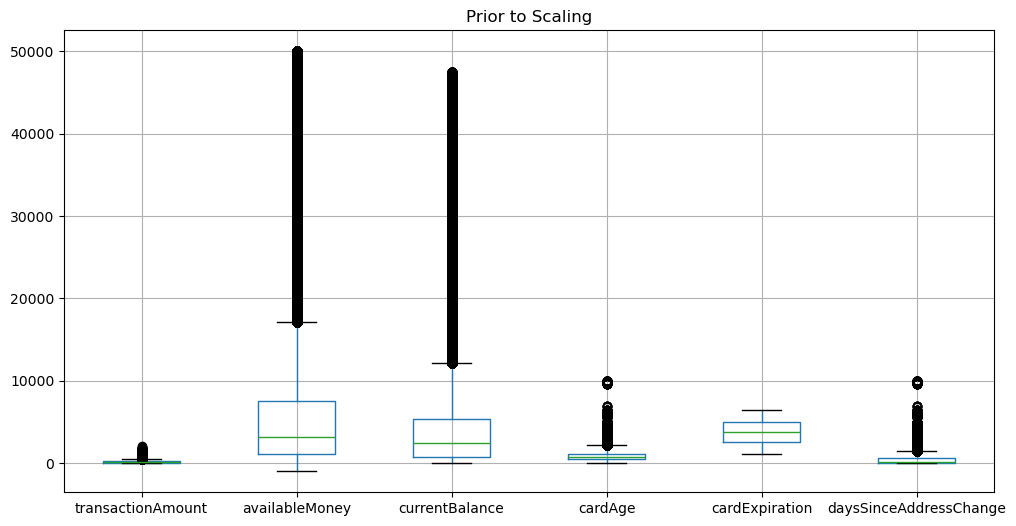

In [8]:
#Visualize numerical features before scaling
numerical_cols = ['transactionAmount', 'availableMoney', 'currentBalance', 'cardAge', 'cardExpiration', 'daysSinceAddressChange']
plt.figure(figsize=(12, 6))
df[numerical_cols].boxplot()
plt.title('Prior to Scaling')
plt.show()

In [10]:
df_logistic = df

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_logistic[numerical_cols] = scaler.fit_transform(df_logistic[numerical_cols])

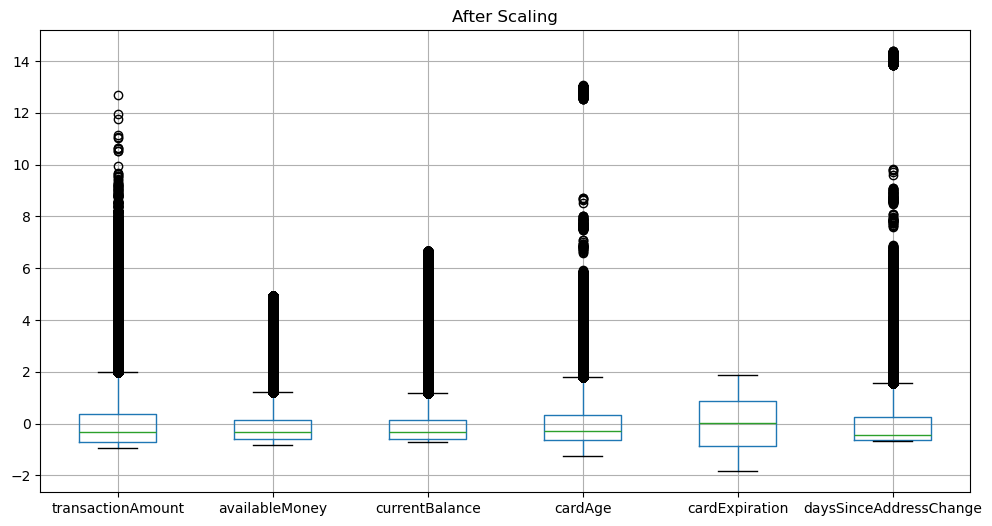

In [14]:
#Visualize numerical features after scaling
plt.figure(figsize=(12, 6))
df_logistic[numerical_cols].boxplot()
plt.title('After Scaling')
plt.show()

### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score, ConfusionMatrixDisplay

In [19]:
X = df_logistic.drop(['isFraud'], axis=1)
y = df_logistic['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the distribution of the class variable
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

isFraud
False    0.984225
True     0.015775
Name: proportion, dtype: float64
isFraud
False    0.984149
True     0.015851
Name: proportion, dtype: float64


In [21]:
#Fit model with default parameter
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

### Model evaluation

In [30]:
#Create a reusable function to visualize ROC
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [32]:
#Create a reusable function to evaluate our model's performance
def eval_model(model, x_test, y_test):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

    plt.show()

    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    #Show ROC Curve
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)

    plot_roc_curve(fpr, tpr, roc_auc)

    results_df = pd.DataFrame()
    results_df['true_class'] = y_test
    results_df['predicted_class'] = list(preds)
    results_df['default_prob'] = probs[:, 1]

    #plot the distribution of probabilities for the estimated classes
    sns.kdeplot(data=results_df[results_df['true_class'] == 0], x='default_prob', legend="No Default", fill=True)
    sns.kdeplot(data=results_df[results_df['true_class'] == 1], x='default_prob', legend="Default", fill=True)

    plt.show()

    #see the true class versus predicted class as a percentage
    print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))

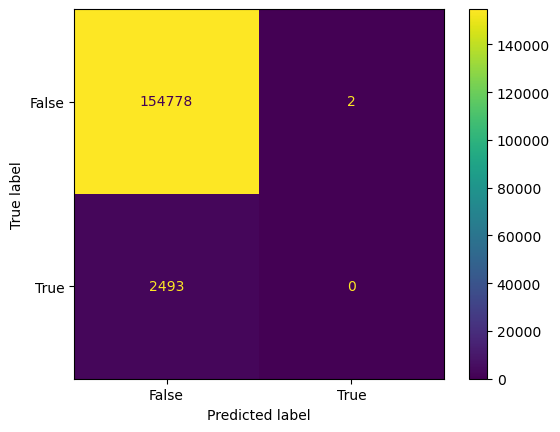



Accuracy:  0.9841358656603486
Precision:  0.0
Recall:  0.0
F1:  0.0
AUC:  0.7420284251648253


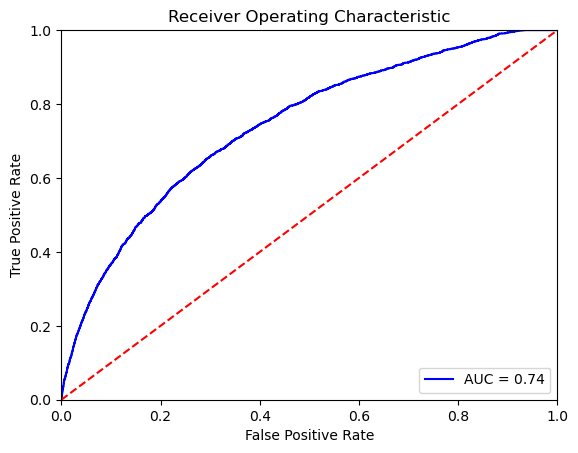

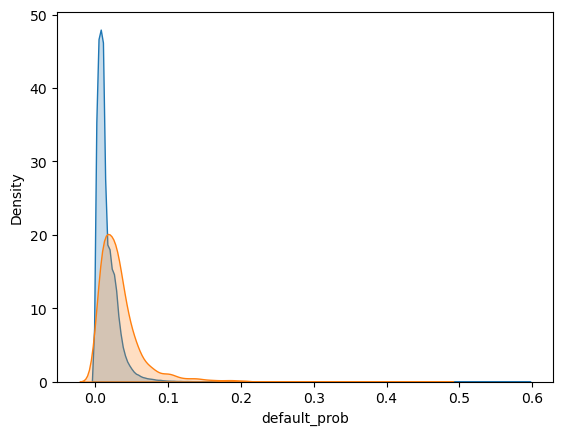

true_class  predicted_class
False       False              0.999987
            True               0.000013
True        False              1.000000
Name: proportion, dtype: float64


In [34]:
eval_model(logistic_model, X_test, y_test)

Our logistic model is struggling with class imbalance and misses all frauds.

### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
df_rfc = df

X = df_rfc.drop(['isFraud'], axis=1)
y = df_rfc['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

isFraud
False    0.984225
True     0.015775
Name: proportion, dtype: float64
isFraud
False    0.984149
True     0.015851
Name: proportion, dtype: float64


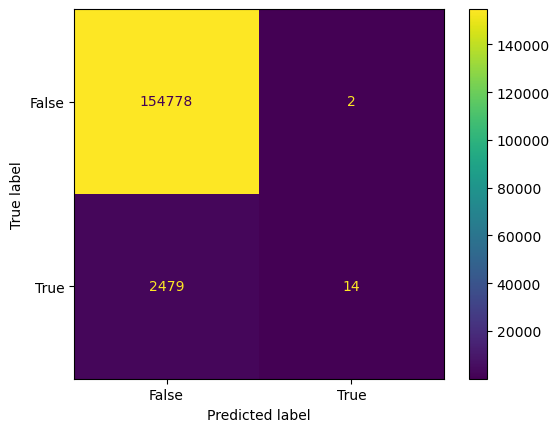



Accuracy:  0.9842248828470239
Precision:  0.875
Recall:  0.005615724027276374
F1:  0.011159824631327222
AUC:  0.7276057882603659


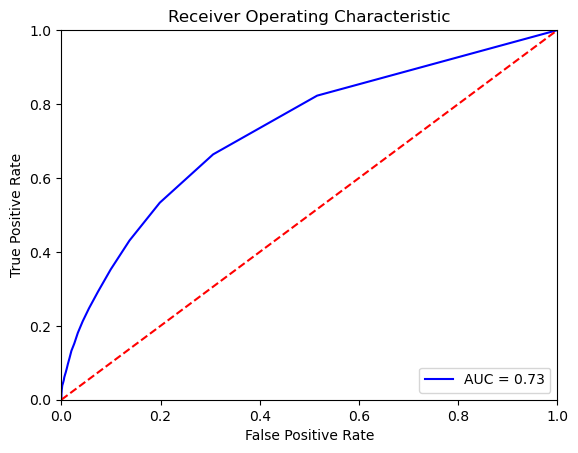

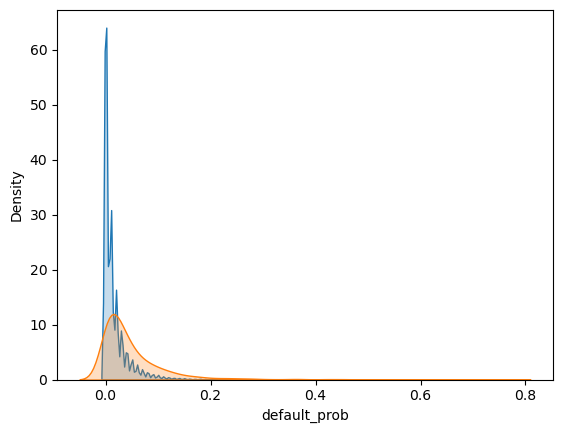

true_class  predicted_class
False       False              0.999987
            True               0.000013
True        False              0.994384
            True               0.005616
Name: proportion, dtype: float64


In [42]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

eval_model(rfc_model, X_test, y_test)

With default parameters, Random Forest seems to have better performance than Logistic Regression so I will investigate more into Random Forest.

### Resampling

In [48]:
from sklearn.utils import resample

In [56]:
#Create a resusable function to downsample/upsample the dataset
def balance_sample(X_train, y_train, sample_mode='up'):
    train_df = X_train.copy()
    train_df['isFraud'] = y_train

    train_minority = train_df[train_df['isFraud'] == 1]
    train_majority = train_df[train_df['isFraud'] == 0]

    train_sampled_df = pd.DataFrame()

    if sample_mode == 'down':
        #Randomly removes samples from the majority class
        train_majority_down = resample(train_majority, replace=False,  n_samples=train_minority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_minority, train_majority_down])
    else:
        train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_majority, train_minority_up])

    X_train_samp = train_sampled_df.drop(['isFraud'], axis=1)
    y_train_samp = train_sampled_df['isFraud']

    return X_train_samp, y_train_samp

In [52]:
#Downsample
X_train_dwn, y_train_dwn = balance_sample(X_train, y_train, sample_mode='down')

print(y_train_dwn.value_counts())
print(y_train_dwn.value_counts(normalize=True))

isFraud
True     9924
False    9924
Name: count, dtype: int64
isFraud
True     0.5
False    0.5
Name: proportion, dtype: float64


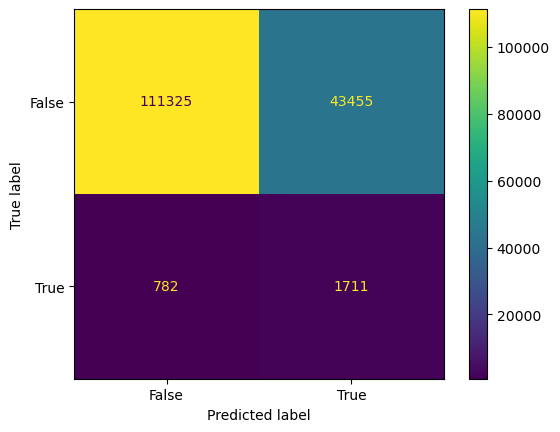



Accuracy:  0.7187247652171701
Precision:  0.03788247797015454
Recall:  0.686321700762134
F1:  0.07180175832476553
AUC:  0.7727543142248096


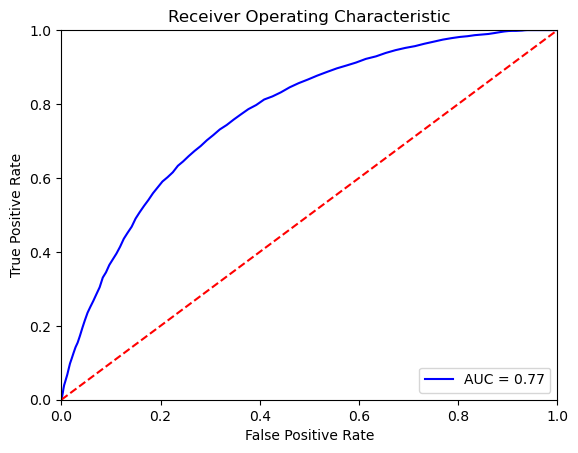

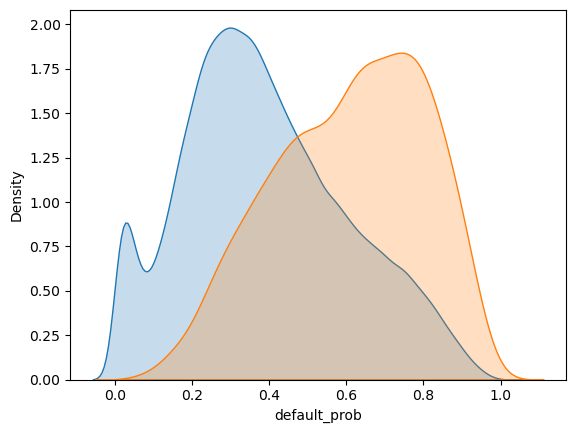

true_class  predicted_class
False       False              0.719247
            True               0.280753
True        True               0.686322
            False              0.313678
Name: proportion, dtype: float64


In [54]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_dwn, y_train_dwn)

eval_model(rfc_model, X_test, y_test)

In [58]:
#Upsample
X_train_up, y_train_up = balance_sample(X_train, y_train, sample_mode='up')

print(y_train_up.value_counts())
print(y_train_up.value_counts(normalize=True))

isFraud
False    619166
True     619166
Name: count, dtype: int64
isFraud
False    0.5
True     0.5
Name: proportion, dtype: float64


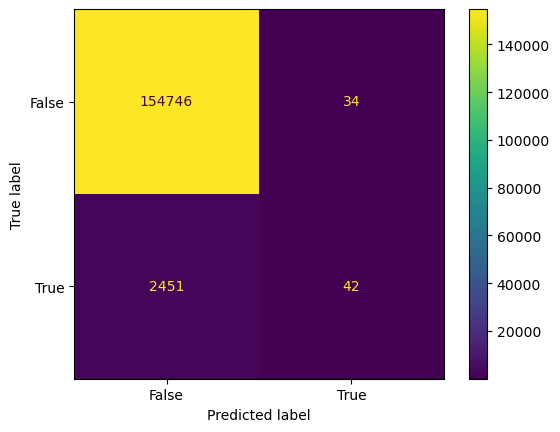



Accuracy:  0.9841994493651167
Precision:  0.5526315789473685
Recall:  0.01684717208182912
F1:  0.0326975476839237
AUC:  0.7293721282493164


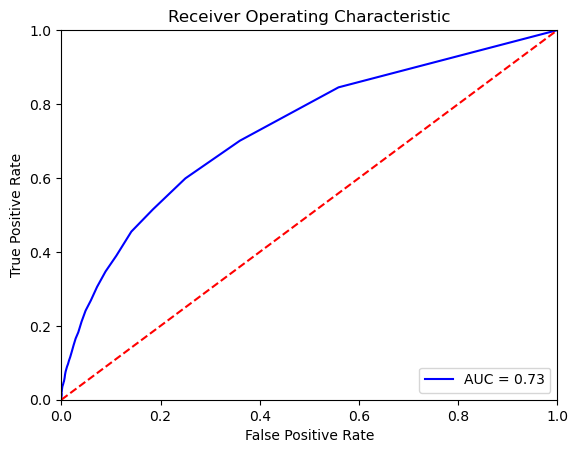

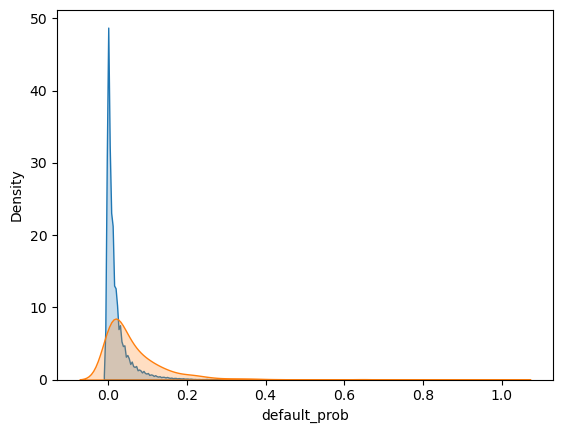

true_class  predicted_class
False       False              0.999780
            True               0.000220
True        False              0.983153
            True               0.016847
Name: proportion, dtype: float64


In [60]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_up, y_train_up)

eval_model(rfc_model, X_test, y_test)

Summary:

Downsampling:
- Accuracy:  72%
- Precision:  3.8%
- Recall:  69%
- F1:  7.2%

Upsampling:
- Accuracy:  98%
- Precision:  55%
- Recall:  1.7%
- F1:  3.3%

The downsampling method results in higher recall but lower precision compared to the upsampling method. This indicates that while downsampling enables the model to identify more fraudulent cases, it also produces more false positives. Since oure primary goal of this model is to detect fraud cases, recall would be more important than precision in this context. Overall, downsampling has better performance as reflected by its higher F1 score.

Both of these model have better perfomance than the first model as well.

### Synthesize new examples using SMOTE

We can use SMOTE to address class imbalance by generating synthetic examples of the minority class (fraud cases)

In [70]:
from imblearn.over_sampling import SMOTE

In [72]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: isFraud
False    619166
True       9924
Name: count, dtype: int64
After SMOTE: isFraud
False    619166
True     619166
Name: count, dtype: int64


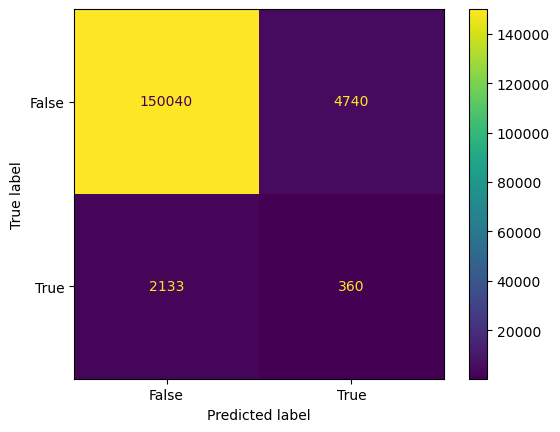



Accuracy:  0.956298919712856
Precision:  0.07058823529411765
Recall:  0.1444043321299639
F1:  0.09482418016594231
AUC:  0.7415447942182288


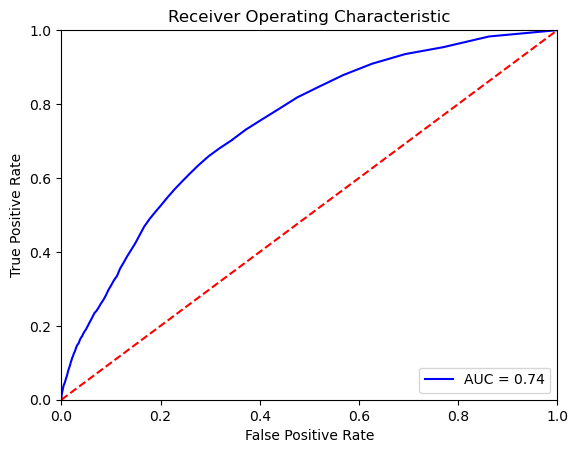

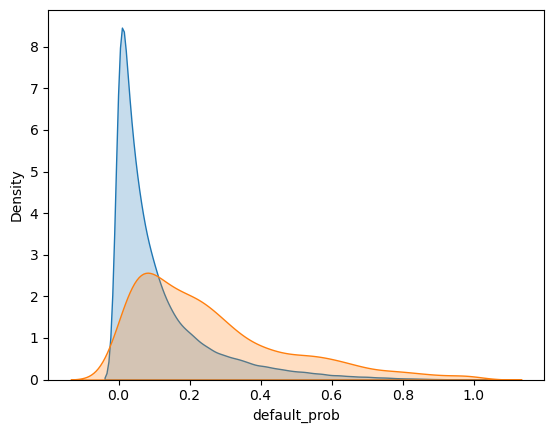

true_class  predicted_class
False       False              0.969376
            True               0.030624
True        False              0.855596
            True               0.144404
Name: proportion, dtype: float64


In [76]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_smote, y_train_smote)

eval_model(rfc_model, X_test, y_test)

### Hyperparameter tuning with GridSearchCV

I will find optimal values for the hyperparameters of our model by using GridSearchCV.

In [80]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Define parameter range - hyperparameters that I want to try
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
#Initialize the model
rfc_model = RandomForestClassifier(random_state=42)
#Set up GridSearchCV
grid_search = GridSearchCV(estimator=rfc_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='accuracy')
#Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

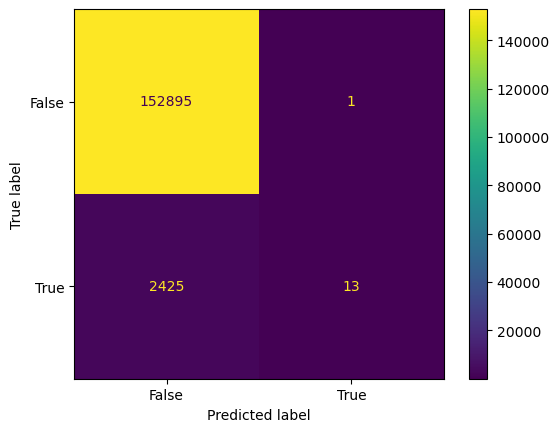



Accuracy:  0.9843820412787928
Precision:  0.9285714285714286
Recall:  0.005332239540607055
F1:  0.010603588907014683
AUC:  0.7117493055486401


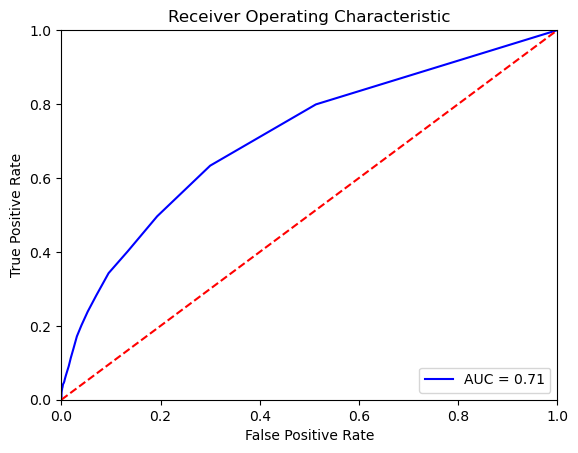

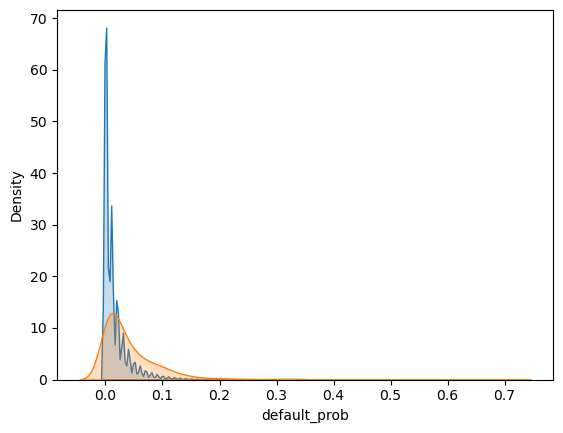

true_class  predicted_class
False       False              0.999993
            True               0.000007
True        False              0.994668
            True               0.005332
Name: proportion, dtype: float64


In [131]:
rfc_model = RandomForestClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, n_estimators=100)
rfc_model.fit(X_train, y_train)

eval_model(rfc_model, X_test, y_test)

### Feature Importance using SHAP

In [125]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 5.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [129]:
import shap
shap.initjs()

In [ ]:
explainer = shap.Explainer(rfc_model)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)